In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import os

PATH = os.path.join("datasets", "price")

In [3]:
def load_data(filename, path= PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path, parse_dates=['Date'])

In [4]:
dataset = load_data("XAU_USD-Historical-Data.csv")

In [5]:
dataset.head()

,Date,Close,Open,High,Low,% Change,% Change Predict
0,2005-01-04,427.65,429.6,427.65,427.65,-0.30%,-0.26%
1,2005-01-05,426.55,427.55,426.55,426.55,-0.26%,-1.23%
2,2005-01-06,421.32,426.77,421.32,421.32,-1.23%,-0.56%
3,2005-01-07,418.95,421.75,418.95,418.95,-0.56%,0.04%
4,2005-01-10,419.12,419.38,419.12,419.12,0.04%,0.78%


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4962 non-null   datetime64[ns]
 1   Close             4962 non-null   object        
 2   Open              4962 non-null   object        
 3   High              4962 non-null   object        
 4   Low               4962 non-null   object        
 5   % Change          4962 non-null   object        
 6   % Change Predict  4962 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 271.5+ KB


In [7]:
dataset.describe()

,Date
count,4962
mean,2014-07-13 13:12:15.671100160
min,2005-01-04 00:00:00
25%,2009-10-08 06:00:00
50%,2014-07-12 12:00:00
75%,2019-04-17 18:00:00
max,2024-01-22 00:00:00


In [8]:
column_list = ['Close', 'Open', 'High', 'Low']
for column in column_list:
    dataset[column] = dataset[column].replace({',': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

column_list = ['% Change', '% Change Predict']
for column in column_list:
    dataset[column] = dataset[column].replace({'%': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4962 non-null   datetime64[ns]
 1   Close             4962 non-null   float64       
 2   Open              4962 non-null   float64       
 3   High              4962 non-null   float64       
 4   Low               4962 non-null   float64       
 5   % Change          4962 non-null   float64       
 6   % Change Predict  4962 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 271.5 KB


In [9]:
dataset.isna().sum().sort_values(ascending=False)

Date                0
Close               0
Open                0
High                0
Low                 0
% Change            0
% Change Predict    0
dtype: int64

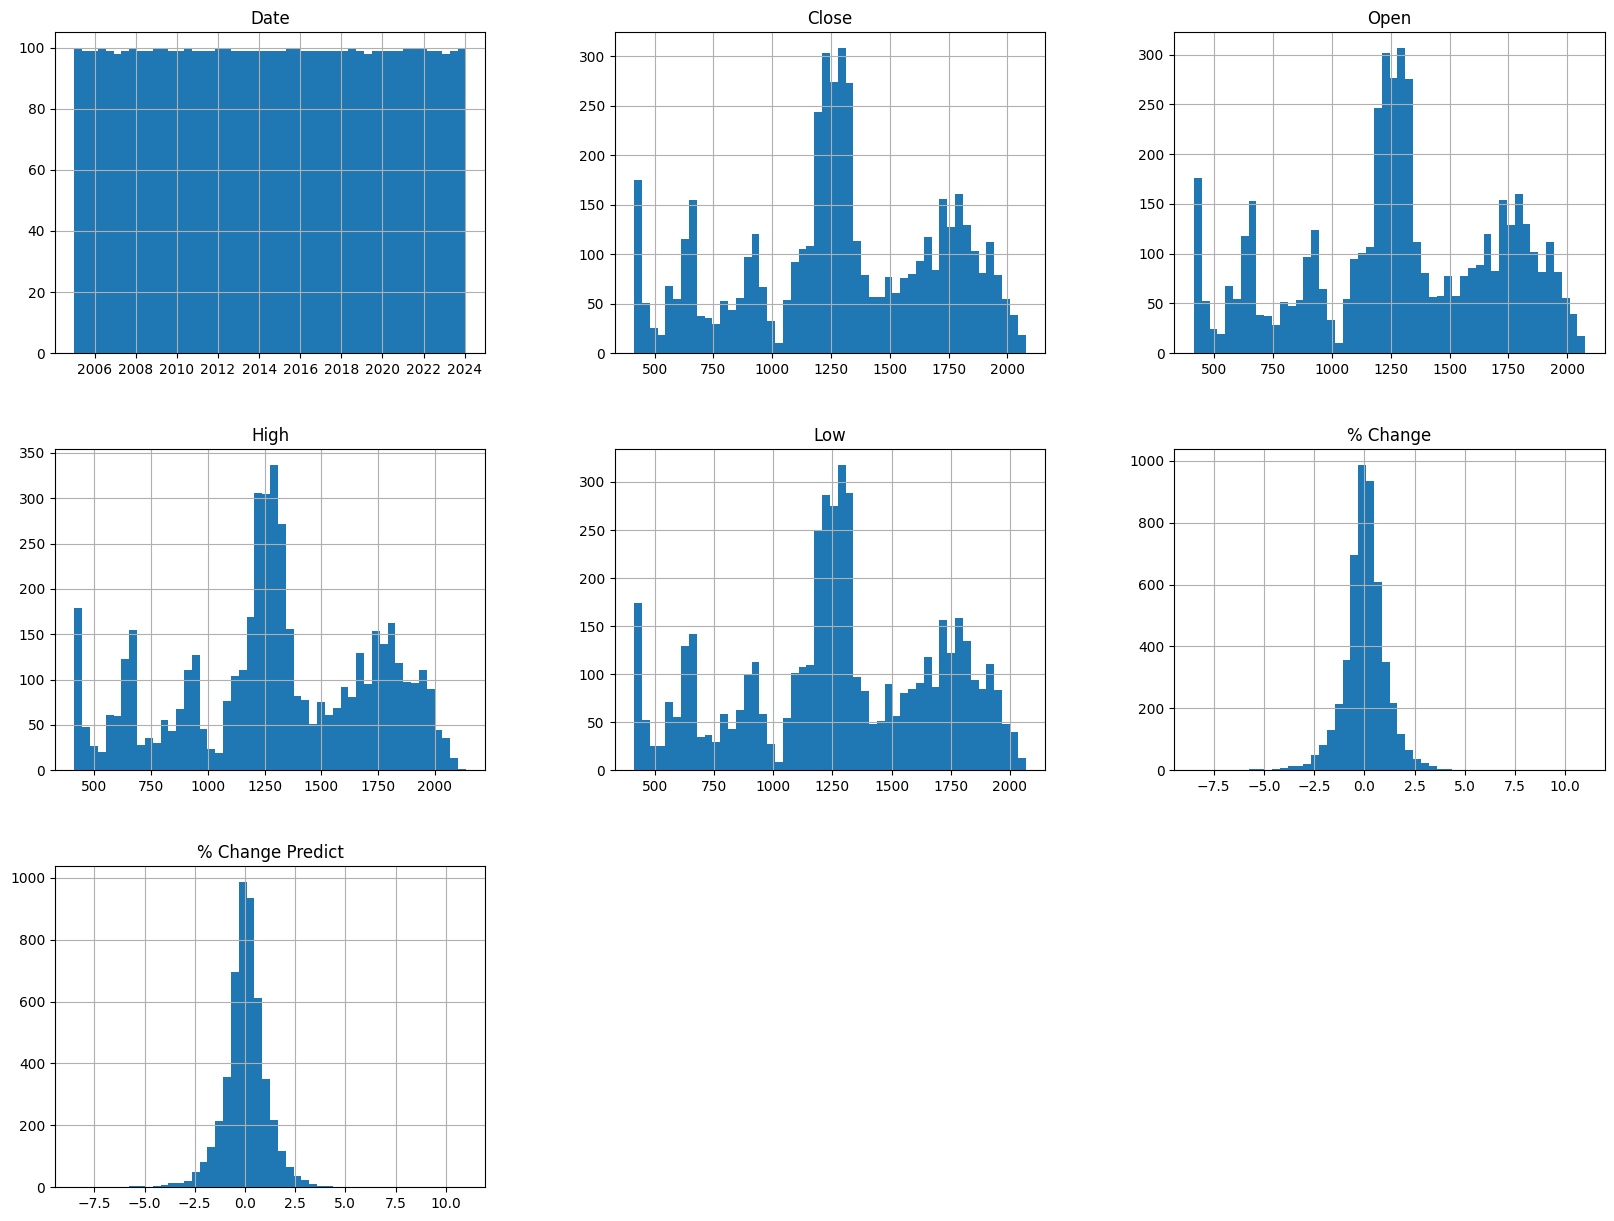

In [10]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(20,15))
plt.show()

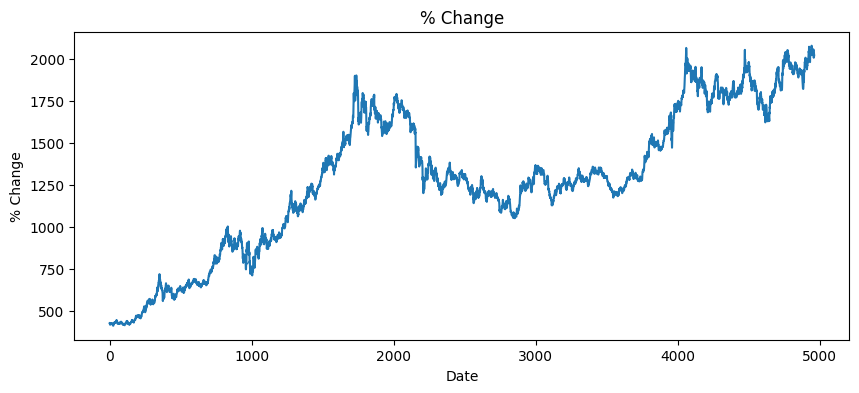

In [11]:
plt.figure(figsize=(10, 4))
plt.title("% Change")
plt.xlabel("Date")
plt.ylabel("% Change")
plt.plot(dataset["Close"])
plt.show()

                      Date     Close      Open      High       Low  % Change  \
Date              1.000000  0.829744  0.829783  0.828445  0.831785 -0.018351   
Close             0.829744  1.000000  0.999477  0.999733  0.999771 -0.003613   
Open              0.829783  0.999477  1.000000  0.999777  0.999695 -0.033828   
High              0.828445  0.999733  0.999777  1.000000  0.999608 -0.019614   
Low               0.831785  0.999771  0.999695  0.999608  1.000000 -0.016760   
% Change         -0.018351 -0.003613 -0.033828 -0.019614 -0.016760  1.000000   
% Change Predict -0.018385 -0.034123 -0.034403 -0.034904 -0.034199  0.006063   

                  % Change Predict  
Date                     -0.018385  
Close                    -0.034123  
Open                     -0.034403  
High                     -0.034904  
Low                      -0.034199  
% Change                  0.006063  
% Change Predict          1.000000  


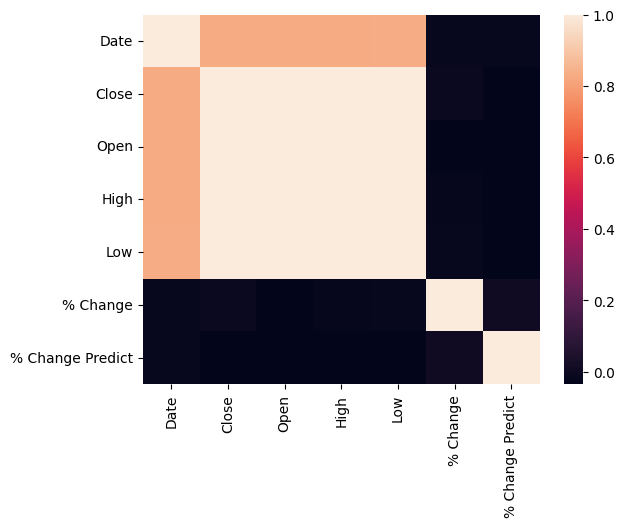

In [12]:
print(dataset.corr())
sns.heatmap(dataset.corr())
plt.show()

In [13]:
close = dataset.filter(['Close'])
numpy_close = close.values

train_data_len = math.ceil(len(numpy_close)*.8)

train_data_len

3970

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close)
scaled_close

array([[0.00892321],
       [0.00826223],
       [0.00511958],
       ...,
       [0.96735368],
       [0.97121139],
       [0.96580339]])

In [15]:
train_data = scaled_close[0:train_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i == 60:
    print(x_train)
    print(y_train)

[array([0.00892321, 0.00826223, 0.00511958, 0.00369547, 0.00379762,
       0.00575652, 0.00800385, 0.00740296, 0.0062192 , 0.00575652,
       0.00615912, 0.00603894, 0.00585867, 0.00838241, 0.00869487,
       0.00578656, 0.00823218, 0.00805192, 0.00841245, 0.00590073,
       0.00498738, 0.00551616, 0.00258382, 0.0010816 , 0.00084125,
       0.        , 0.00019228, 0.00289629, 0.00485519, 0.00785963,
       0.0077034 , 0.00755919, 0.00880303, 0.00879101, 0.00874294,
       0.01306934, 0.0130393 , 0.01281096, 0.01329768, 0.01371229,
       0.01198774, 0.01192765, 0.01049754, 0.01273885, 0.0131114 ,
       0.01671674, 0.01671674, 0.01777431, 0.01985939, 0.01705324,
       0.01687297, 0.01853744, 0.01540079, 0.01595361, 0.0111465 ,
       0.00868285, 0.00724072, 0.00736089, 0.00808196, 0.00785963])]
[0.00816007691383247]


In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3910, 60, 1)

In [18]:
model = tf.keras.Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10

3910/3910 [==============================] - 76s 19ms/step - loss: 6.8831e-04
Epoch 2/10
3910/3910 [==============================] - 79s 20ms/step - loss: 2.5405e-04
Epoch 3/10
3910/3910 [==============================] - 98s 25ms/step - loss: 1.8735e-04
Epoch 4/10
3910/3910 [==============================] - 94s 24ms/step - loss: 1.8326e-04
Epoch 5/10
3910/3910 [==============================] - 75s 19ms/step - loss: 1.5511e-04
Epoch 6/10
3910/3910 [==============================] - 75s 19ms/step - loss: 1.5692e-04
Epoch 7/10
3910/3910 [==============================] - 77s 20ms/step - loss: 1.3385e-04
Epoch 8/10
3910/3910 [==============================] - 76s 20ms/step - loss: 1.4806e-04
Epoch 9/10
3910/3910 [==============================] - 91s 23ms/step - loss: 1.3840e-04
Epoch 10/10
3910/3910 [==============================] - 124s 32ms/step - loss: 1.2809e-04


In [20]:
test_data = scaled_close[train_data_len-60:, :]

x_test = []
y_test = numpy_close[train_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [21]:
x_test = np.array(x_test)

In [22]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

31/31 [==============================] - 1s 16ms/step


In [24]:
rmse = np.sqrt(np.mean(pred-y_test)**2)
rmse

18.655433019822645

C:\Users\T480s\AppData\Local\Temp\ipykernel_7752\365441623.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = pred


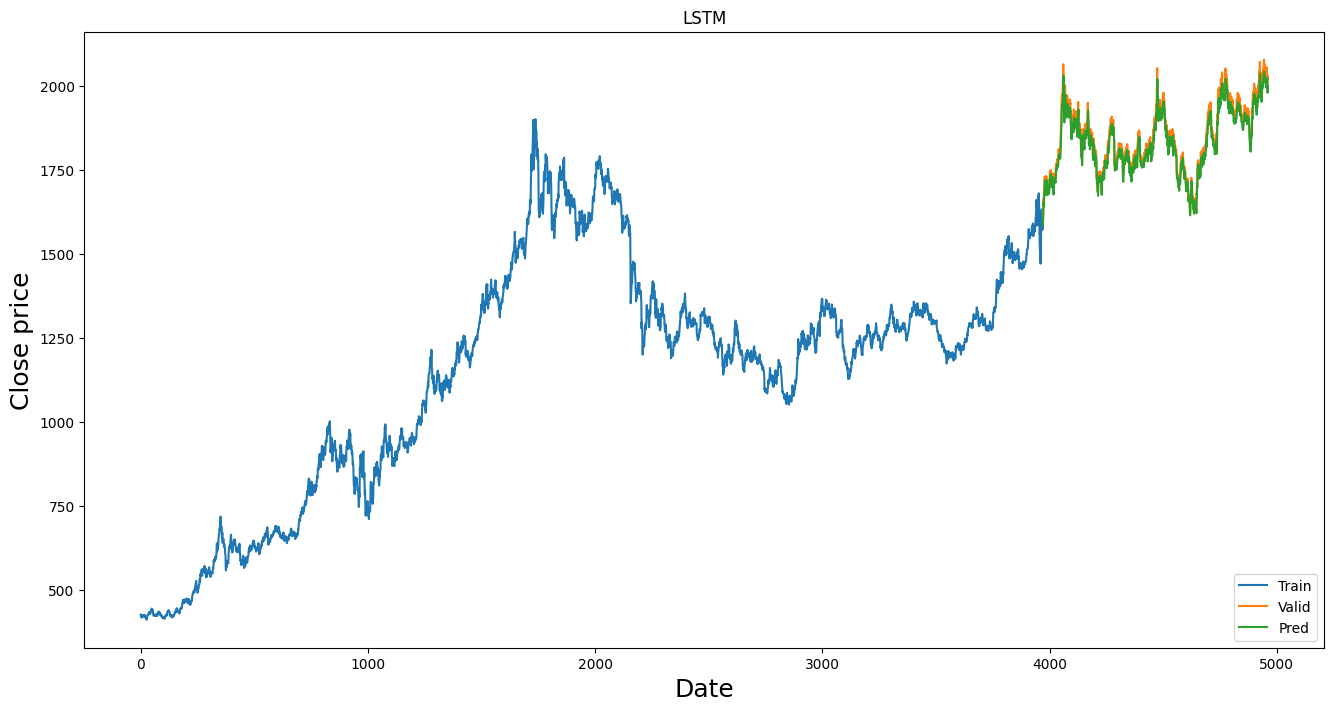

In [25]:
train = close[:train_data_len]
valid = close[train_data_len:]
valid['Pred'] = pred

plt.figure(figsize=(16,8))
plt.title('LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Pred']])
plt.legend(['Train', 'Valid', 'Pred'], loc='lower right')
plt.show()